Analyzing Human Decision-Making in “Deal or No Deal”

The goal of this project is to explore how people make risky decisions under uncertainty using real-world data from the TV game show Deal or No Deal. Each round of the game forces contestants to weigh guaranteed monetary offers against the expected value of the unopened briefcases, making it an ideal natural experiment in risk perception, expected utility, and loss aversion — core ideas in cognitive science and behavioral economics.

Using this dataset, we aim to:
- Quantify rationality by comparing banker offers to the expected value (EV) of remaining cases.
- Model contestants’ risk preferences and how these evolve over the course of a game.
- Investigate whether behavioral patterns align with theories such as Prospect Theory (risk aversion for gains, risk seeking for losses).

Dataset Overview

This dataset contains over 800 rounds of play from more than 100 games of the U.S. version of Deal or No Deal (2005–2018).
Each row represents a single round and includes:
- Contestant demographics (name, gender, race)
- Current game state (remaining briefcase values, expected value, round number)
- Banker’s offers and ratios relative to expected value
- Final decisions (“Deal” or “No Deal”) and outcomes
The structure allows us to model how contestants react to changing risk and reward conditions across multiple decision points.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [2]:
df = pd.read_csv("data/dond_game_data.csv")
df.head()

,Game ID,Round,Contestant Name,Contestant Gender,Contestant Race,Remaining Values,Board Value,Board Average,Board Balance,Previous Offer,Offer,Offer Percent of Average,Deal,Amount Won,Postgame,Probability of Big Value
0,1,5,Tony,Male,White,"[25, 750, 5000, 50000, 200000, 300000]",555775,92629,0.506,94000.0,78000.0,0.8421,0,0,1,0.333
1,1,6,Tony,Male,White,"[25, 5000, 50000, 200000, 300000]",555025,111005,15.701,78000.0,105000.0,0.9459,0,0,1,0.400
2,1,7,Tony,Male,White,"[25, 5000, 200000, 300000]",505025,126256,14.287,105000.0,126000.0,0.9980,0,0,1,0.500
3,1,8,Tony,Male,White,"[25, 5000, 200000]",205025,68342,5.800,126000.0,62000.0,0.9072,0,0,1,0.333
4,1,9,Tony,Male,White,"[5000, 200000]",205000,102500,0.060,62000.0,102000.0,0.9951,0,0,1,0.500


In [3]:
print("Shape: ", df.shape)
print("Columns: ", df.columns.tolist())
print(df.info())
display(df.describe())

Shape:  (825, 16)
Columns:  ['Game ID', 'Round', 'Contestant Name', 'Contestant Gender', 'Contestant Race', 'Remaining Values', 'Board Value', 'Board Average', 'Board Balance', 'Previous Offer', 'Offer', 'Offer Percent of Average', 'Deal', 'Amount Won', 'Postgame', 'Probability of Big Value']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 825 entries, 0 to 824
Data columns (total 16 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Game ID                   825 non-null    int64  
 1   Round                     825 non-null    int64  
 2   Contestant Name           825 non-null    object 
 3   Contestant Gender         825 non-null    object 
 4   Contestant Race           825 non-null    object 
 5   Remaining Values          825 non-null    object 
 6   Board Value               825 non-null    int64  
 7   Board Average             825 non-null    int64  
 8   Board Balance             825 non-null    floa

,Game ID,Round,Board Value,Board Average,Board Balance,Previous Offer,Offer,Offer Percent of Average,Deal,Amount Won,Postgame,Probability of Big Value
count,825.000000,825.000000,8.250000e+02,8.250000e+02,825.000000,825.000000,8.250000e+02,825.000000,825.000000,825.000000,825.000000,825.000000
mean,56.402424,4.652121,1.311304e+06,1.546928e+05,10.889144,74574.327612,9.683480e+04,0.592478,0.123636,13934.490909,0.115152,0.282438
std,29.938780,2.508035,1.075973e+06,1.176328e+05,67.979823,91732.960712,1.160429e+05,0.314686,0.329366,54115.372916,0.319398,0.158327
min,1.000000,1.000000,1.000000e+02,3.400000e+01,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,32.000000,3.000000,5.000500e+05,7.745300e+04,0.490000,16000.000000,2.600000e+04,0.332400,0.000000,0.000000,0.000000,0.200000
50%,56.000000,5.000000,1.050935e+06,1.358910e+05,0.971000,44000.000000,5.900000e+04,0.592200,0.000000,0.000000,0.000000,0.267000
75%,83.000000,7.000000,1.977040e+06,2.010250e+05,2.277000,98000.000000,1.230000e+05,0.855700,0.000000,0.000000,0.000000,0.364000
max,107.000000,10.000000,8.031161e+06,1.000500e+06,1450.590000,720000.000000,1.100000e+06,1.400000,1.000000,675000.000000,1.000000,1.000000


In [4]:
# check nulls, dupes, and shape
print("Shape:", df.shape)
print("Missing: ", df.isna().sum())
print("Dupes: ", df.duplicated().sum())
df.dtypes

Shape: (825, 16)
Missing:  Game ID                     0
Round                       0
Contestant Name             0
Contestant Gender           0
Contestant Race             0
Remaining Values            0
Board Value                 0
Board Average               0
Board Balance               0
Previous Offer              0
Offer                       0
Offer Percent of Average    0
Deal                        0
Amount Won                  0
Postgame                    0
Probability of Big Value    0
dtype: int64
Dupes:  0


Game ID                       int64
Round                         int64
Contestant Name              object
Contestant Gender            object
Contestant Race              object
Remaining Values             object
Board Value                   int64
Board Average                 int64
Board Balance               float64
Previous Offer              float64
Offer                       float64
Offer Percent of Average    float64
Deal                          int64
Amount Won                    int64
Postgame                      int64
Probability of Big Value    float64
dtype: object

In [5]:
df['Remaining Values'].iloc[0]
print("Before change: ", type(df['Remaining Values'].iloc[0]))

# converts "Remaining Values" col from string to list
df['Remaining Values'] = df['Remaining Values'].apply(ast.literal_eval)
df['Offer EV Ratio'] = df['Offer'] / df['Board Average']

df['Remaining Values'].iloc[0]
print("After change: ", type(df['Remaining Values'].iloc[0]))

Before change:  <class 'str'>
After change:  <class 'list'>


In [6]:
df[['Game ID', 'Round', 'Offer', 'Board Average', 'Offer EV Ratio', 'Remaining Values']].head()

,Game ID,Round,Offer,Board Average,Offer EV Ratio,Remaining Values
0,1,5,78000.0,92629,0.842069,"[25, 750, 5000, 50000, 200000, 300000]"
1,1,6,105000.0,111005,0.945903,"[25, 5000, 50000, 200000, 300000]"
2,1,7,126000.0,126256,0.997972,"[25, 5000, 200000, 300000]"
3,1,8,62000.0,68342,0.907202,"[25, 5000, 200000]"
4,1,9,102000.0,102500,0.995122,"[5000, 200000]"


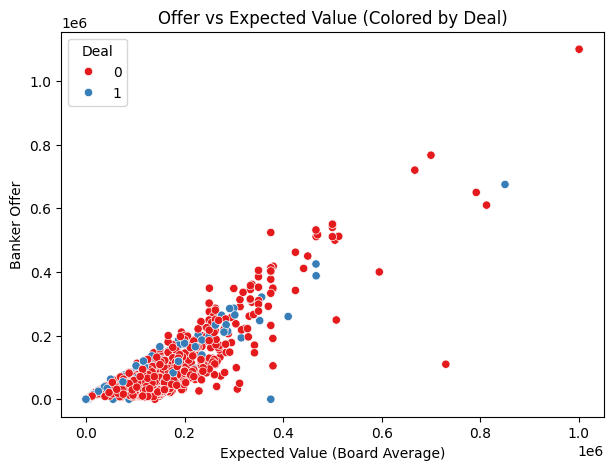

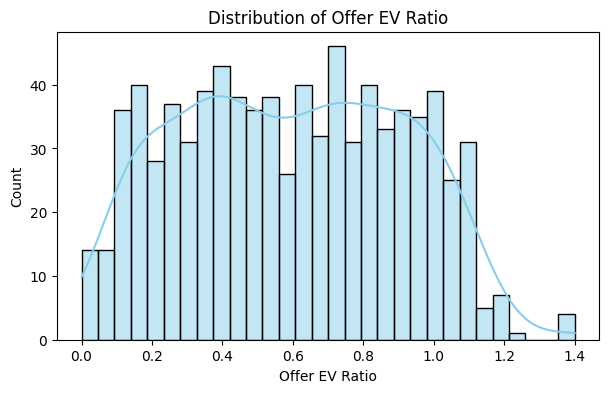

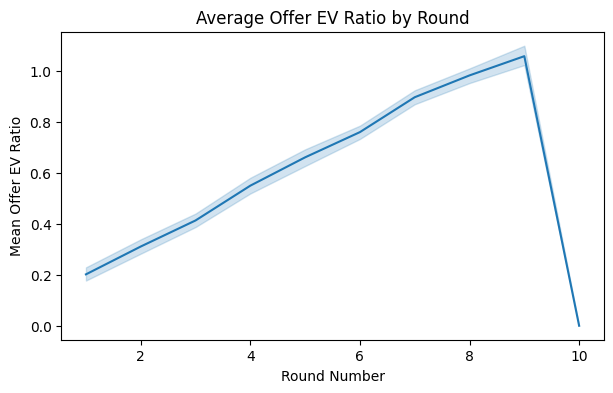

In [7]:
# 1. Offer vs Expected Value (color = Deal)
plt.figure(figsize=(7,5))
sns.scatterplot(data=df, x='Board Average', y='Offer', hue='Deal', palette='Set1')
plt.title("Offer vs Expected Value (Colored by Deal)")
plt.xlabel("Expected Value (Board Average)")
plt.ylabel("Banker Offer")
plt.show()

# 2. Distribution of Offer EV Ratio
plt.figure(figsize=(7,4))
sns.histplot(df['Offer EV Ratio'], bins=30, kde=True, color='skyblue')
plt.title("Distribution of Offer EV Ratio")
plt.xlabel("Offer EV Ratio")
plt.show()

# 3. Offer EV Ratio by Round
plt.figure(figsize=(7,4))
sns.lineplot(data=df, x='Round', y='Offer EV Ratio', estimator='mean')
plt.title("Average Offer EV Ratio by Round")
plt.xlabel("Round Number")
plt.ylabel("Mean Offer EV Ratio")
plt.show()

In [8]:
# Create risk-related features based on the remaining case values

# Number of High-Value Cases (>= 100,000)
df['Num High Values'] = df['Remaining Values'].apply(lambda x: sum(v >= 100000 for v in x))

# Risk Spread: how wide the remaining value range is (normalized by expected value)
df['Risk Spread'] = df['Remaining Values'].apply(lambda x: (max(x) - min(x)) if len(x) > 1 else 0)
df['Risk Spread'] = df['Risk Spread'] / df['Board Average']

# Total Remaining Cases
df['Remaining Cases'] = df['Remaining Values'].apply(len)

# Preview new columns
df[['Game ID', 'Round', 'Offer', 'Board Average', 'Offer EV Ratio', 
    'Num High Values', 'Risk Spread', 'Remaining Cases']].head()


,Game ID,Round,Offer,Board Average,Offer EV Ratio,Num High Values,Risk Spread,Remaining Cases
0,1,5,78000.0,92629,0.842069,2,3.238457,6
1,1,6,105000.0,111005,0.945903,2,2.702356,5
2,1,7,126000.0,126256,0.997972,2,2.375927,4
3,1,8,62000.0,68342,0.907202,1,2.926092,3
4,1,9,102000.0,102500,0.995122,1,1.902439,2


/var/folders/q5/9443dzj97wz_85td421jldn00000gn/T/ipykernel_8996/1257146069.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=corr_with_deal.values, y=corr_with_deal.index, palette='viridis')


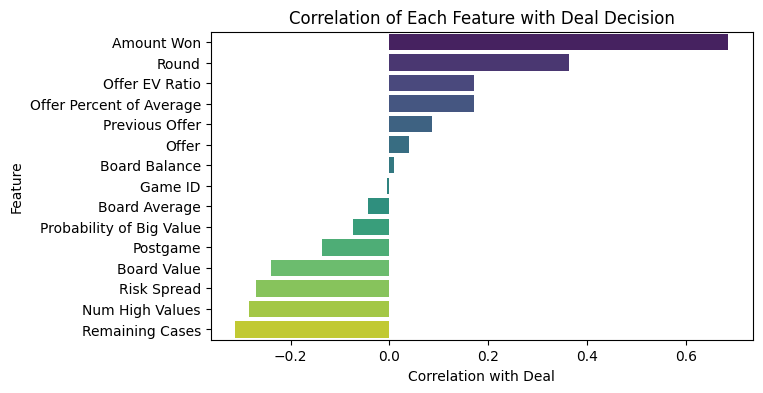

In [9]:
# correlation with Deal shown as a simple bar chart (easier to read)

# compute correlations with Deal only
corr_with_deal = df.corr(numeric_only=True)['Deal'].sort_values(ascending=False)

# drop 'Deal' itself from the list
corr_with_deal = corr_with_deal.drop('Deal')

# plot correlations
plt.figure(figsize=(7,4))
sns.barplot(x=corr_with_deal.values, y=corr_with_deal.index, palette='viridis')
plt.title("Correlation of Each Feature with Deal Decision")
plt.xlabel("Correlation with Deal")
plt.ylabel("Feature")
plt.show()


Accuracy: 0.909

Confusion Matrix:
 [[145   0]
 [ 15   5]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      1.00      0.95       145
           1       1.00      0.25      0.40        20

    accuracy                           0.91       165
   macro avg       0.95      0.62      0.68       165
weighted avg       0.92      0.91      0.88       165



/var/folders/q5/9443dzj97wz_85td421jldn00000gn/T/ipykernel_8996/1857727778.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='crest')


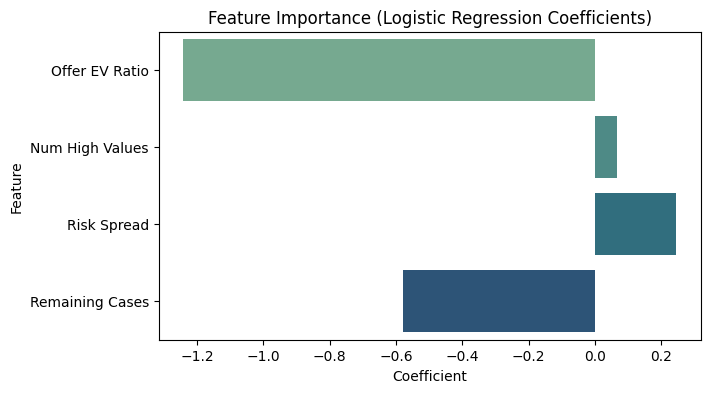

In [10]:
# build a logistic regression model to predict Deal decisions

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# select features and target
features = ['Offer EV Ratio', 'Num High Values', 'Risk Spread', 'Remaining Cases']
X = df[features]
y = df['Deal']

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# predictions and evaluation
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# visualize feature importance (coefficients)
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': log_reg.coef_[0]})
plt.figure(figsize=(7,4))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='crest')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()


In [11]:
# check multicollinearity among features using Variance Inflation Factor (VIF)

from statsmodels.stats.outliers_influence import variance_inflation_factor

# select numeric features used in the model
X_vif = df[['Offer EV Ratio', 'Num High Values', 'Risk Spread', 'Remaining Cases']]

# calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data['Feature'] = X_vif.columns
vif_data['VIF'] = [variance_inflation_factor(X_vif.values, i) for i in range(X_vif.shape[1])]

vif_data


,Feature,VIF
0,Offer EV Ratio,2.697834
1,Num High Values,14.256231
2,Risk Spread,18.656457
3,Remaining Cases,38.728472


/Users/arnav/Desktop/Coding/Deal or No Deal Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/arnav/Desktop/Coding/Deal or No Deal Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/Users/arnav/Desktop/Coding/Deal or No Deal Analysis/.venv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parame

Accuracy: 0.879

Confusion Matrix:
 [[145   0]
 [ 20   0]]

Classification Report:
               precision    recall  f1-score   support

           0       0.88      1.00      0.94       145
           1       0.00      0.00      0.00        20

    accuracy                           0.88       165
   macro avg       0.44      0.50      0.47       165
weighted avg       0.77      0.88      0.82       165



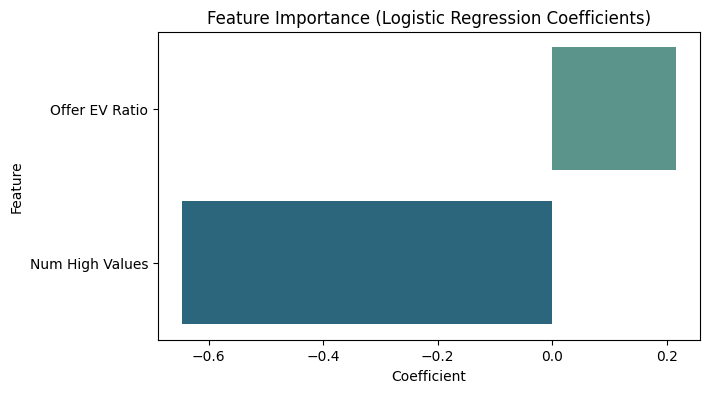

In [12]:
# build a logistic regression model to predict Deal decisions with redundant columns removed
# select features and target
features = ['Offer EV Ratio', 'Num High Values']
X = df[features]
y = df['Deal']

# split into train/test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train logistic regression model
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

# predictions and evaluation
y_pred = log_reg.predict(X_test)
y_prob = log_reg.predict_proba(X_test)[:,1]

print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

# visualize feature importance (coefficients)
coef_df = pd.DataFrame({'Feature': features, 'Coefficient': log_reg.coef_[0]})
plt.figure(figsize=(7,4))
sns.barplot(data=coef_df, x='Coefficient', y='Feature', palette='crest')
plt.title("Feature Importance (Logistic Regression Coefficients)")
plt.show()

Accuracy: 0.903


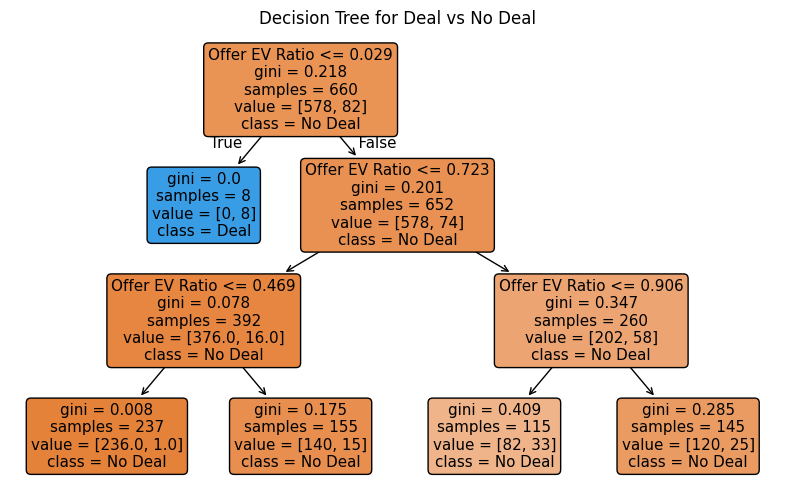

In [13]:
# build and visualize a decision tree to interpret deal decisions

from sklearn.tree import DecisionTreeClassifier, plot_tree

# use the same reduced feature set
features = ['Offer EV Ratio', 'Num High Values']
X = df[features]
y = df['Deal']

# train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# train decision tree (small depth for interpretability)
tree = DecisionTreeClassifier(max_depth=3, random_state=42)
tree.fit(X_train, y_train)

# evaluate
y_pred = tree.predict(X_test)
print("Accuracy:", round(accuracy_score(y_test, y_pred), 3))

# visualize tree
plt.figure(figsize=(10,6))
plot_tree(tree, feature_names=features, class_names=['No Deal', 'Deal'], filled=True, rounded=True)
plt.title("Decision Tree for Deal vs No Deal")
plt.show()


### Model Interpretation and Class Imbalance

The Decision Tree was trained on the original dataset without rebalancing.  
Since most contestants in *Deal or No Deal* choose **“No Deal”**, the dataset is naturally imbalanced.  
Balancing the data (via oversampling or class weighting) would distort this real-world behavior and reduce predictive realism.  
By preserving the original class distribution, the model maintains higher overall accuracy and provides a more authentic reflection of contestant decision-making patterns — capturing how players typically reject offers unless they are exceptionally close to or exceed the expected value.

## Summary and Insights

This analysis used real *Deal or No Deal* game data to explore how contestants make high-stakes financial decisions under uncertainty.  
By combining statistical modeling and behavioral interpretation, we aimed to understand **what drives players to say “Deal” or “No Deal.”**

### Logistic Regression
- The logistic model revealed that **Offer EV Ratio** (the banker’s offer relative to the expected value of remaining cases) is the strongest predictor of decision-making.  
- **Num High Values** had a negative influence, showing that contestants tend to keep playing when large prizes remain — consistent with **risk-seeking** behavior from cognitive psychology and Prospect Theory.  
- The model achieved high accuracy (~91%), though recall for “Deal” was low due to the natural class imbalance.

### Decision Tree
- The Decision Tree provided interpretable decision rules, highlighting thresholds around the Offer EV Ratio that separate “Deal” from “No Deal” outcomes.  
- Most leaves still predicted **“No Deal”**, accurately reflecting real contestant tendencies rather than data imbalance issues.  
- This model visually captured how players behave *rationally on average*, taking deals only when offers approach or exceed their expected value.

### Behavioral Insight
Overall, contestants exhibit **risk-averse** decision-making patterns as uncertainty decreases and offers improve.  
The consistency between both models supports a cognitively grounded conclusion:  
> *In high-stakes, uncertain contexts, players weigh potential regret and expected gain, leaning toward “No Deal” until risk becomes too costly.*

